# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


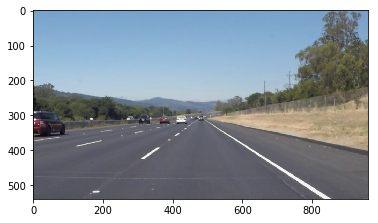

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def extend_lines(lines):
    """
    Extend input line segments to have the same y coordinates. This function is used by the function draw_lines_continuous
    that combines multiple line segments into a single line.
    Input: 2d array of line segments, each row is a single line segment and has a format [x1 y1 x2 y2]
    Output: the same format as input
    Logic:
        1) Compute minimal y coordinate (min_y) as the minimum of y coordinates of all segments
        2) Compute maximal y coordinate (max_y) as the maximum of the previously computed maximal y coordinate and 
        the maximum of y coordinated of all segments. We use previously computed maximal y coordinate since
        the maximal y coordinate of continuous lines is almost constant over time. 
        3) Extend input lines to min_y and max_y, while preserving their original slopes.
    """
    
    global max_y_global
    
    extended_lines = np.array([]).reshape(0,4)
    if lines.shape[0] > 0:
        
        # find min_y and max_y in nonempty lines (empty line can happen when there is no detected line)
        lines_nonempty = lines[lines.sum(axis=1)>0]
        min_y = int(lines_nonempty[:,[1,3]].min().min())
        max_y = int(lines_nonempty[:,[1,3]].max().max())
        if max_y < max_y_global:
            max_y = max_y_global
        elif max_y > max_y_global:
            max_y_global = max_y
            
        # extend input lines to min_y and max_y, while preserving their original slopes   
        for x1, y1, x2, y2 in lines:
            if x1 + y1 + x2 + y2 == 0:  # extreme case when the line is empty, can happen when 
                                        # there is no detected line
                extended_lines = np.append(extended_lines, [[0, 0, 0, 0]], axis = 0) # skip this line
                continue
            
            # compute slope of the line
            slope = (y2 - y1) / (x2 - x1)
                
            # find the values of x's that correspond to min_y and max_y
            b = y2 - slope * x2
            if y1 < y2: # right line
                min_x = (min_y - b)/slope
                max_x = (max_y - b)/slope
                extended_lines = np.append(extended_lines, [[min_x, min_y, max_x, max_y]], axis = 0) 
            else: # left line
                min_x = (max_y - b)/slope
                max_x = (min_y - b)/slope
                extended_lines = np.append(extended_lines, [[min_x, max_y, max_x, min_y]], axis = 0)
                
    return extended_lines    
                        
def draw_lines_continuous(img, lines, color=[255, 0, 0], thickness=2):
    """
    Find two continuous lines that represent left and right lane
    Input: original image frame (img), lines detected by Hough transform
    Output: black image with two (or less) red lines on it. Each line represents a lane. If no lane is found then
            no line is shown. 
    Logic: 1) We split the image into two equal parts, left and right. We try to find a right lane line in the right part and
           left lane line in the left part. Notice that when the car drifts and the left lane appears in the right part of 
           the image (or when the right lane appears in the left part of the image), the lane line(s) will not be detected. 
           This might be a signal that the car is not in the right position. 
           
           2) Based on previous experiments, we assume that the left and right lane lines have slopes in ranges 
           [-0.75, -0.55] and [0.55, 0.75] respectively. We remove all line segments with the slopes outside of these ranges.
           
           3) We build histogram of the slopes of the detected lines and find the most common range of slopes (e.g. (0.61,0.66)). We use 3 bins for creating
           histograms. We remove all line segments with the slopes outside of the most common range of slopes.
           
           4) After that we build a continuous line that connects minimal and maximal x and y points of the lines in 
           the previously found most common range of slopes. If the absolute value of the slope of the new continuous line is 
           still in [0.55,0.75] range then we add this line to the list of lines that are lane candidates. 
           
           5) We extend the candidate lines to have the same minimal and maximal coordinates using the function extend_lines.
           After this extension we have up to two continuous lines that represent lanes in the current frame. These are still
           not the continuous lines that are drawn in the image.
           
           6) After detecting the lanes in the current frame, we average them with the lanes drawn in the previous frame
           using the formula:
           
           right/left lane in the current frame = (1-alpha) * right/left lane drawn in the previous frame + 
                                                  alpha * right/left lane in the current frame
                                                        
           If at step 2 we didn't find left or right lane in the current frame then we define the corresponding lane 
           at the current frame as the one that was drawn in the previous frame. 
           We also use an expiration counter to limit the number of frames where we show exactly the same lane. When 
           the lane is updated the counter is set to its maximal value. When there is no update, i.e. when we could 
           not detect a lane in the current frame, the counter is reduced by one. When the counter reaches zero value 
           we delete the previously detected lane. 
           
           7) Finally we extend the lanes in the current frame to have the same minimal and maximal coordinates using 
           the function extend lines. The lanes lines after this extension are the final ones and are drawn over the black 
           image.
    
    """
    
    global curr_lines, expiration_time
    
    # parameters of continuous line detection 
    slope_threshold_low = 0.55      # minimal absolute value of slope
    slope_threshold_high = 0.75     # maximal absolute value of slope
    alpha = 0.1                     # weight of the new lines when averaging with previously detected lines
    n_bins = 3                        # number of bins used in histograms (when finding the most common slopes)
    
    # compute slopes of all line segments
    lines_slopes = np.array([((y2-y1)/(x2-x1), x1, y1, x2, y2) for line in lines 
                                                               for x1, y1, x2, y2 in line if x2 != x1])
    
    # parameters of left and right lines
    parameters = np.array([[-1,0,img.shape[1]/2],               # left line
                           [1,img.shape[1]/2,img.shape[1]]])    # right line
    candidate_lines = np.array([]).reshape(0,4)
    
    for multiplier, left, right in parameters:
        # get all line segments with the slope between slope_threshold_low and slope_threshold_high
        # in the given part of the picture
        directional_lines_slopes = lines_slopes[(lines_slopes[:,0]*multiplier > slope_threshold_low) &
                                                (lines_slopes[:,0]*multiplier < slope_threshold_high) &
                                                (lines_slopes[:,1] >= left) &
                                                (lines_slopes[:,3] >= left) &
                                                (lines_slopes[:,1] <= right) &
                                                (lines_slopes[:,3] <= right), :]
            
        if directional_lines_slopes.shape[0] == 0:
            continue
        
        # compute histograms of the slopes and find most common range of slopes
        hist, bin_edges = np.histogram(directional_lines_slopes[:,0], bins=n_bins)
        indices = np.argsort(hist)
        largest_index = indices[len(indices)-1]
        slope_range = (bin_edges[largest_index], bin_edges[largest_index+1])
        
        # get line segments that are in the most common slope range
        slope_lines = directional_lines_slopes[(directional_lines_slopes[:,0] >= slope_range[0]) & 
                                               (directional_lines_slopes[:,0] <= slope_range[1]),:]
        
        # in the rest of this for loop we build a new continuous line by connecting exteme points
        # of the line segments found in the previous step.
        # A. find extreme points of the line segments found in the previous step
        min_x = slope_lines[:,[1,3]].min().min()
        max_x = slope_lines[:,[1,3]].max().max()
        min_y = slope_lines[:,[2,4]].min().min()
        max_y = slope_lines[:,[2,4]].max().max()
        
        # B. check if the slope of the new continuous line is between slope_threshold_low and slope_threshold_high
        new_slope = multiplier * (min_y-max_y)/(min_x-max_x)
        if new_slope * multiplier <= slope_threshold_low or new_slope * multiplier >= slope_threshold_high:
            continue
         
        # C. create a new continuous line by connecting extreme points 
        if multiplier < 0: # left line
            candidate_lines = np.append(candidate_lines, [[min_x, max_y, max_x, min_y]], axis = 0)
        else: # right line
            candidate_lines = np.append(candidate_lines, [[min_x, min_y, max_x, max_y]], axis = 0)
    
    # extend newly created continuous lines to have the same minimal and maximal y coordinates
    extended_candidate_lines = extend_lines(candidate_lines)
    
    # update expiration time counter of the continuous lines shown in the last frame
    expiration_time = expiration_time - 1
    curr_lines[expiration_time == 0,:] = [0,0,0,0]
    
    # compute average between continuous lines shown in the last frame and new ones
    for x1, y1, x2, y2 in extended_candidate_lines:
        if y1 > y2: # left line
            curr_index = 0  # index of the left line in the curr_lines array
        else: # right line
            curr_index = 1 # index of the right line in the curr_lines array
        if curr_lines[curr_index,:].sum() == 0: 
            # previously detected continuous line has expired, just set the current line as the new one
            curr_lines[curr_index,:] = [x1, y1, x2, y2]
        else:
            # current line is a weighted average between previous and the new ones 
            curr_lines[curr_index,:] = (1-alpha) * curr_lines[curr_index,:] + alpha * np.array([x1, y1, x2, y2])
        expiration_time[curr_index] = max_expiration_time   # reset the expiration time counter of the updated line
    
    # extend current lines to have the same minimal and maximal y coordinates
    curr_lines = extend_lines(curr_lines)
    
    # draw red continuous lines over black image
    line_image = np.copy(img)*0
    for x1, y1, x2, y2 in curr_lines:
        cv2.line(line_image, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness=10)
    
    return line_image        

# this is modified version of the original hough_lines function
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns a list of lines detected by Hough transform
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # we removed the following three lines from the original function:
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    #return line_img
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

import os

# expiration time for detected lines
max_expiration_time = 30

# Parameters of Canny transform
low_threshold = 50
high_threshold = 150

# Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 4    # minimum number of votes (intersections in Hough grid cell) 
min_line_length = 25 #minimum number of pixels making up a line   
max_line_gap = 10   # maximum gap in pixels between connectable line segments  

indir = "test_images/"
outdir = "test_images_output/"

image_files = os.listdir(indir)

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
for image_file in image_files:
    image = mpimg.imread(indir + image_file)
    
    # Grayscale the image
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, 5)

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Choose region of interest
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(imshape[1]/2-20, imshape[0]/2+50), 
                         (imshape[1]/2+20, imshape[0]/2+50), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    draw_lines(image, lines)
    mpimg.imsave(outdir + image_file, image)

## Show detectes lines

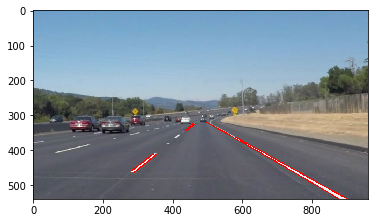

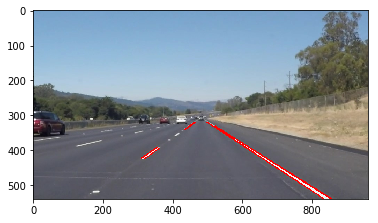

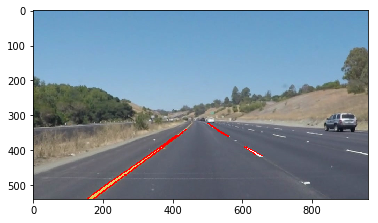

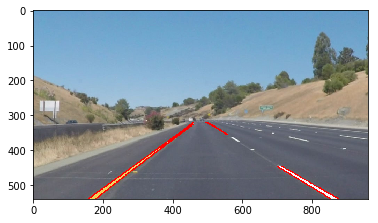

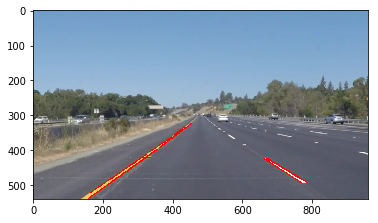

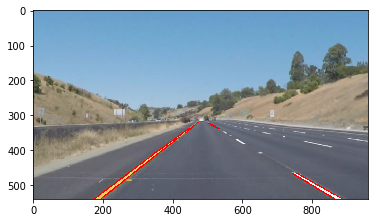

In [6]:
image_files = os.listdir(outdir)
    
for image_file in image_files:
    image = mpimg.imread(outdir + image_file)
    plt.figure()
    plt.imshow(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
outdir = "test_videos_output/"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [9]:
def process_image(image):
    """
    Pipeline for finding line segments in the region of interest.
    Input: image
    Output: image with the red line segments drawn over it
    """

    # Grayscale the image
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, 5)

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Choose region of interest
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(imshape[1]/2-20, imshape[0]/2+50), 
                         (imshape[1]/2+20, imshape[0]/2+50), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    draw_lines(image, lines)
    
    return image

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 64.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
def process_image_continuous(image):
    """
    Pipeline for finding continuous lines thsat represent lanes.
    Input: image
    Output: image with up to two continous pink lines drawn over it. 
    """

    # Grayscale the image
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, 5)

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Choose region of interest
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(imshape[1]/2-20, imshape[0]/2+50), 
                         (imshape[1]/2+20, imshape[0]/2+50), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the black image
    line_image = draw_lines_continuous(image, lines, thickness=10)
    
    # Merge original images and lines
    merged_image = weighted_img(line_image, image)
    
    return merged_image

### Detect line segments

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Detect continuous lines

In [15]:
curr_lines = np.zeros((2,4), dtype=np.int32)
expiration_time = np.array([max_expiration_time, max_expiration_time])
max_y_global = 0

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_continuous)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:12<00:00, 54.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 13 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

### Detect line segments 

In [17]:
challenge_output = 'test_videos_output/challenge_segments.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_segments.mp4
[MoviePy] Writing video test_videos_output/challenge_segments.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 27.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_segments.mp4 

Wall time: 10.2 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Detect continuous lines

In [19]:
curr_lines = np.zeros((2,4), dtype=np.int32)
expiration_time = np.array([max_expiration_time, max_expiration_time])
max_y_global = 0

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_continuous)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:08<00:00, 28.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 9.76 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))